# Task

Choose, implement and test a method that would take two images as input, and give out the probability with which these two images could be considered identical.

# Training enviroment

In [1]:
import os
import gc
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import torchvision
from torchvision import transforms

from tqdm.notebook import tqdm

In [2]:
SEED = 1234
BATCH_SIZE = 16
DATASET_PATH = 'dataset/'
TRAIN_LEN = 7000

In [3]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Preprocess

In [4]:
products_barcode = []

for filename in os.listdir(DATASET_PATH):
    barcode = filename[:filename.index('_')]
    if barcode not in products_barcode:
        products_barcode.append(barcode)

products_barcode.sort()

10000 unique barcodes

In [5]:
len(products_barcode)

10000

Shuffle list of products, then split to train and test

In [6]:
seed_everything(SEED)
np.random.shuffle(products_barcode)

In [7]:
train_barcodes =  products_barcode[:TRAIN_LEN]
test_barcodes =  products_barcode[TRAIN_LEN:]

In [8]:
class ImagesDataset(Dataset):
    def __init__(self, dataset_path: str, barcodes: list, transforms):

        self.dataset_path = dataset_path
        self.barcodes = barcodes
        self.transforms = transforms

    def __len__(self):
        return len(self.barcodes)
    
    def get_image(self, img_path):
        image = Image.open(img_path).convert('RGB')
        return self.transforms(image)

    def __getitem__(self, idx):
        barcode = self.barcodes[idx]
        first_img_path = os.path.join(self.dataset_path, barcode + '_1.jpg')
        second_img_path = os.path.join(self.dataset_path, barcode + '_2.jpg')

        return self.get_image(first_img_path), self.get_image(second_img_path)

In [10]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.RandomRotation(10, fill=1),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
])

In [16]:
seed_everything(SEED)


train_dataset = ImagesDataset(DATASET_PATH, train_barcodes, train_transforms)
test_dataset = ImagesDataset(DATASET_PATH, test_barcodes, test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
def show_products(image1, image2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 20))
    
    for ax in axes.flat:
        ax.set_yticks([])
        ax.set_xticks([])
        
    axes[0].imshow(image1.permute(1, 2, 0))
    axes[1].imshow(image2.permute(1, 2, 0))

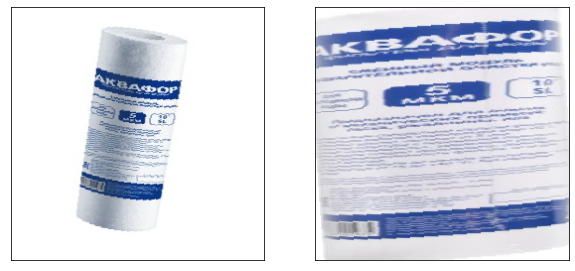

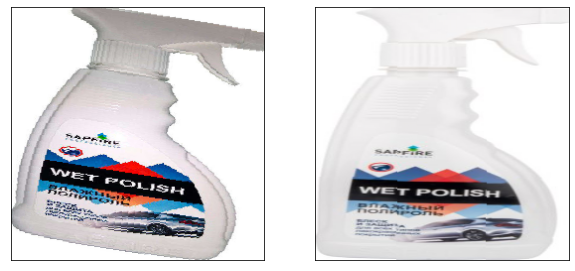

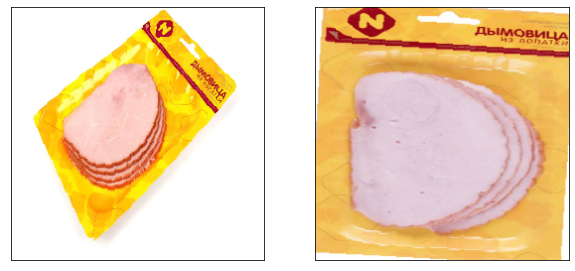

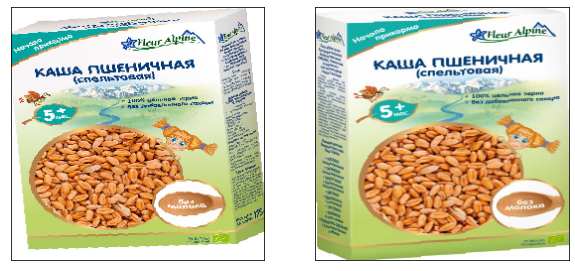

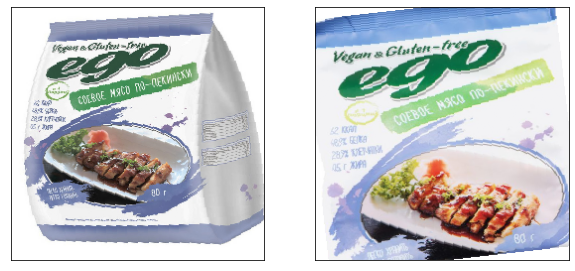

In [18]:
X1, X2 = iter(train_loader).next()
for i in range(5):
    show_products(X1[i], X2[i])

# Модель

All pictures of the same product should be approximately similar in color and shape. But in fact, because of the rebranding, the old packaging of one product may not look much like the new one. Also, the goods can be shot at different angles or there may be extra elements in the image, for example, text. Therefore, highlighting the product in the image, and then comparing the two products from the images with each other is quite a difficult task. A convolutional neural network was chosen to solve it, since it can analyze both the entire image and its parts. Also, the convolutional neural network is able to find more complex hidden dependencies in addition to the color or shape of the packaging.

I chose simple convolutional neural network architecture. It is light, its weights weigh only 11MB, but at the same time it determines similar products with an accuracy of 86%.

The model consists of two parts:

1) Convolutional part extracts features from each image individually.

2) Linear part takes a concatenated pair of features as input and returns the probability that these two images are one product.

In [22]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, 
                      stride=2, padding=3, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3),
            nn.BatchNorm2d(64),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, 
                      stride=1, padding=2, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, 
                      stride=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256),

            nn.Conv2d(in_channels=256, out_channels=400, kernel_size=3, 
                      stride=1, bias=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(400),

            nn.Conv2d(in_channels=400, out_channels=512, kernel_size=2, 
                      stride=1, bias=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )

        self.similarity = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, X1, X2):
        """
        The learning process:
    
            1. Two batches of the same size are extracted from the dataset. 

            2. These two butches are concatenated, fed to the feature extractor input, and from all images 
               features are extracted independently.

            3. Further, for each pair of images, features are concatenated. The similarity input receives concatenated features
            of pairs of images.
        """
    
        batch_size = len(X1)
        images = torch.cat((X1, X2), 0)
        features = self.feature_extractor(images).mean([2, 3])
        first_features = features[:batch_size]
        second_features = features[batch_size:]
        return self.similarity(torch.cat((first_features, second_features), 1))

# Training

In [25]:
def training(model, train, optimizer, loss_fn, scheduler=None):
    losses = []
    accs = []
    
    for values in tqdm(train):
        model.train()
        optimizer.zero_grad()
        
        X1, X2 = values
        X1, X2 = X1.cuda(), X2.cuda()
        
        batch_size = len(X1)
        half_batch_size = batch_size//2
        
        true_target = torch.ones(batch_size, 1).float().cuda()
        false_target = torch.zeros(half_batch_size, 1).float().cuda()
        
        # X1 and X2 consist similar products, right answer - 1
        true_similarity = model(X1, X2)
        acc = torch.sum(true_similarity >= 0.5)
        loss = loss_fn(true_similarity, true_target)
                
        # right answer - 0, because these are different products
        false_similarity = model(X1[:half_batch_size], X2[half_batch_size:])
        loss += loss_fn(false_similarity, false_target)
        acc += torch.sum(false_similarity < 0.5)
        
        false_similarity = model(X1[half_batch_size:], X2[:half_batch_size])
        loss += loss_fn(false_similarity, false_target)
        acc += torch.sum(false_similarity < 0.5)
                
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.item())
        accs.append(acc.item()/(2 * batch_size))
        
        # clear gpu
        gc.collect()
        torch.cuda.empty_cache() 
        del X1
        del X2
        del loss
        del acc
        del true_target
        del false_target
        del true_similarity
        del false_similarity
        
    print('Loss', np.mean(losses))
    print('Acss', np.mean(accs))

In [26]:
def validation(model, test):
    model.eval()
    accs = []
    
    for values in tqdm(test):
        X1, X2 = values
        X1, X2 = X1.cuda(), X2.cuda()
        
        batch_size = len(X1)
        half_batch_size = batch_size//2

        true_similarity = model(X1, X2)
        acc = torch.sum(true_similarity >= 0.5)

        false_similarity = model(X1[:half_batch_size], X2[half_batch_size:])
        acc += torch.sum(false_similarity < 0.5)

        false_similarity = model(X1[half_batch_size:], X2[:half_batch_size])
        acc += torch.sum(false_similarity < 0.5)

        accs.append(acc.item()/(2 * batch_size))
    
        gc.collect()
        torch.cuda.empty_cache() 
        
        del X1
        del X2
        del acc
        del true_similarity
        del false_similarity
        
    print('Acss', np.mean(accs))

In [20]:
seed_everything(SEED)

In [23]:
model = Model().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=7e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)
loss_fn = torch.nn.BCELoss()

In [19]:
for epoch in range(6):
    print(f'----------------{epoch}----------------')
    print('\nTraining')
    training(model, train_loader, optimizer, loss_fn, scheduler=scheduler)
    
    print('\nValidation')
    validation(model, test_loader)

----------------0----------------

Training


  0%|          | 0/438 [00:00<?, ?it/s]

C:\Users\Pirozhok\Documents\millionagents_test\venv\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss 1.1937844188518176
Acss 0.7913812785388128

Validation


  0%|          | 0/188 [00:00<?, ?it/s]

Acss 0.8502327127659575
----------------1----------------

Training


  0%|          | 0/438 [00:00<?, ?it/s]

Loss 0.9230228763192756
Acss 0.8565211187214612

Validation


  0%|          | 0/188 [00:00<?, ?it/s]

Acss 0.8656914893617021
----------------2----------------

Training


  0%|          | 0/438 [00:00<?, ?it/s]

Loss 0.8003921243085709
Acss 0.8782819634703196

Validation


  0%|          | 0/188 [00:00<?, ?it/s]

Acss 0.8761635638297872
----------------3----------------

Training


  0%|          | 0/438 [00:00<?, ?it/s]

Loss 0.7951463445612829
Acss 0.8788527397260274

Validation


  0%|          | 0/188 [00:00<?, ?it/s]

Acss 0.879654255319149
----------------4----------------

Training


  0%|          | 0/438 [00:00<?, ?it/s]

Loss 0.761290315657718
Acss 0.8859874429223744

Validation


  0%|          | 0/188 [00:00<?, ?it/s]

Acss 0.8779920212765957
----------------5----------------

Training


  0%|          | 0/438 [00:00<?, ?it/s]

Loss 0.7842472112274061
Acss 0.8823487442922374

Validation


  0%|          | 0/188 [00:00<?, ?it/s]

Acss 0.8804853723404256


In [20]:
torch.save(model.state_dict(), 'similarity_model.pt')

# Results

In [30]:
def precision(pred, y):
    tp = np.sum((pred == 1) * (y == 1))
    fp = np.sum((pred == 1) * (y == 0))
    return tp / (tp + fp)

def recall(pred, y):
    tp = np.sum((pred == 1) * (y == 1))
    fn = np.sum((pred == 0) * (y == 1))
    return tp / (tp + fn)

def accuracy(pred, y):
    return np.sum((pred== y))/len(pred)

In [31]:
def model_prediction(model, data):
    y = []
    pred = []
    
    model.eval()
    for values in tqdm(data):
        X1, X2 = values
        X1, X2 = X1.cuda(), X2.cuda()
        
        batch_size = len(X1)
        half_batch_size = batch_size//2
        
        y += [1 for _ in range(batch_size)]
        y += [0 for _ in range(batch_size)]
        

        true_similarity = model(X1, X2)
        pred += list(true_similarity.detach().cpu().flatten() >= 0.5)

        false_similarity = model(X1[:half_batch_size], X2[half_batch_size:])
        pred += list(false_similarity.detach().cpu().flatten() >= 0.5)    

        false_similarity = model(X1[half_batch_size:], X2[:half_batch_size])
        pred += list(false_similarity.detach().cpu().flatten() >= 0.5) 
        
        gc.collect()
        torch.cuda.empty_cache() 
        
        del X1
        del X2
        del true_similarity
        del false_similarity
        
        
    pred = np.array(pred)
    y = np.array(y)
    
    return pred, y

def results(model, data):
    pred, y = model_prediction(model, data)
        
    print('Precision: ', precision(pred, y))
    print('Recall: ', recall(pred, y))
    print('Accuracy: ', accuracy(pred, y))

In [32]:
model = Model().cuda()
model.load_state_dict(torch.load('similarity_model.pt'))
model.eval()

Model(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(256, 400, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [33]:
seed_everything(SEED)

train_dataset = ImagesDataset(DATASET_PATH, train_barcodes, test_transforms)
test_dataset = ImagesDataset(DATASET_PATH, test_barcodes, test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [34]:
results(model, test_loader)

  0%|          | 0/188 [00:00<?, ?it/s]

Precision:  0.8962526023594726
Recall:  0.861
Accuracy:  0.8806666666666667


In [35]:
results(model, train_loader)

  0%|          | 0/438 [00:00<?, ?it/s]

Precision:  0.900602852521688
Recall:  0.875
Accuracy:  0.8892142857142857


## Test visualizations

### Similar products

Предсказание модели:  tensor([0.8969])


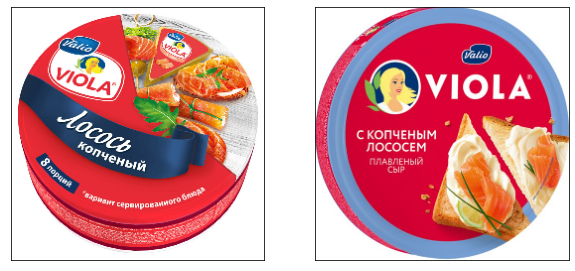


Предсказание модели:  tensor([0.8743])


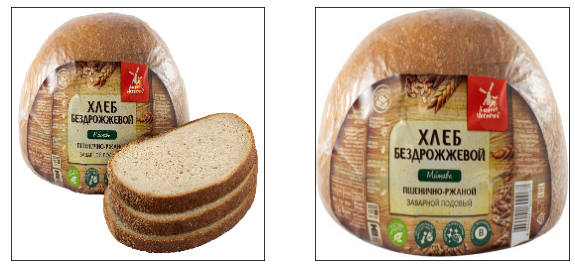


Предсказание модели:  tensor([0.4875])


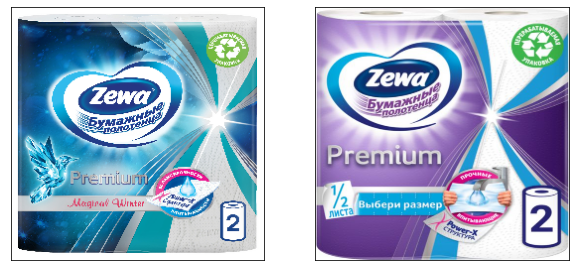


Предсказание модели:  tensor([0.1527])


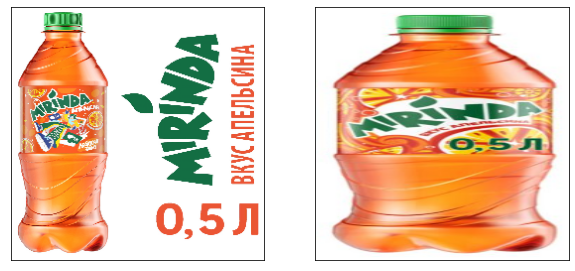


Предсказание модели:  tensor([0.9768])


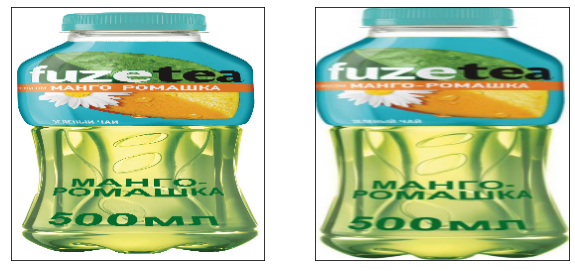

In [37]:
X1, X2 = iter(test_loader).next()
predictions = model(X1[:5].cuda(), X2[:5].cuda()).detach().cpu()
for i in range(5):
    print('Предсказание модели: ', predictions[i])
    show_products(X1[i], X2[i])
    plt.show()
    print()

### Different products

Предсказание модели:  tensor([0.0438])


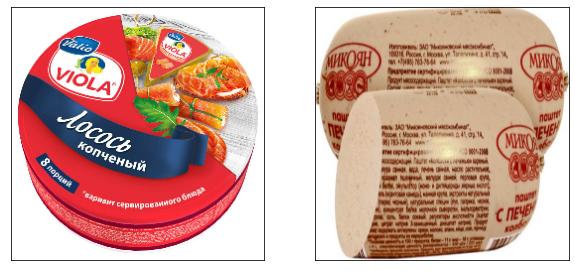


Предсказание модели:  tensor([0.0467])


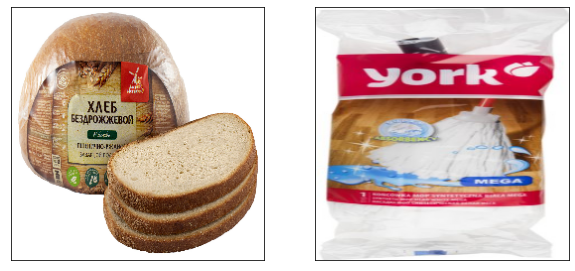


Предсказание модели:  tensor([0.3102])


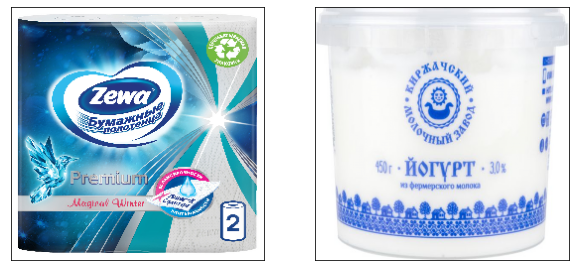


Предсказание модели:  tensor([0.0310])


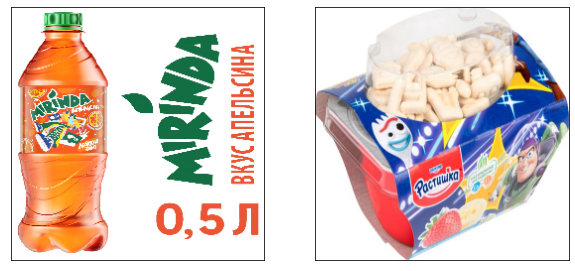


Предсказание модели:  tensor([0.0084])


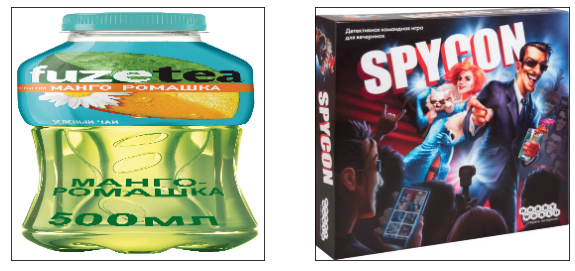

In [38]:
X1, X2 = iter(test_loader).next()
predictions = model(X1[:5].cuda(), X2[5:10].cuda()).detach().cpu()
for i in range(5):
    print('Предсказание модели: ', predictions[i])
    show_products(X1[i], X2[5 + i])
    plt.show()
    print()